In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
plt.style.use("dark_background")

### Fetching data:

In [2]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Displaying data on 2D plane:

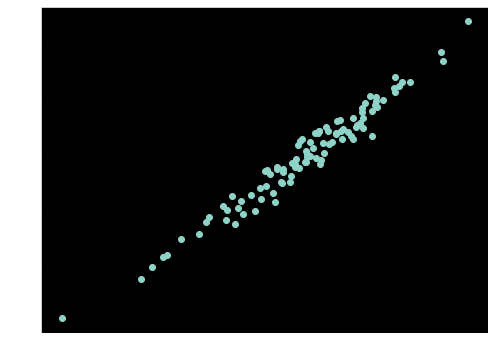

In [3]:
fig=plt.figure(figsize=(8,6))
plt.scatter(X[:,0],y)
plt.show()

on X axis -> independent variables values, 
on Y axis -> dependent variable values

##### Appending 1 to each instance/data point in order to calculate bias:

In [4]:
X_train_augmented = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_train_augmented

array([[ 1.00000000e+00,  3.61419367e-02],
       [ 1.00000000e+00,  9.84919842e-01],
       [ 1.00000000e+00,  1.82891913e-02],
       [ 1.00000000e+00, -1.22091575e-01],
       [ 1.00000000e+00,  2.15268581e-01],
       [ 1.00000000e+00, -1.19097569e+00],
       [ 1.00000000e+00, -3.12651896e-01],
       [ 1.00000000e+00,  5.65738306e-01],
       [ 1.00000000e+00,  2.00784295e+00],
       [ 1.00000000e+00,  3.07968855e-01],
       [ 1.00000000e+00,  1.15003572e+00],
       [ 1.00000000e+00,  1.39198619e+00],
       [ 1.00000000e+00, -2.02646325e-01],
       [ 1.00000000e+00,  1.64529543e-01],
       [ 1.00000000e+00, -9.74236334e-01],
       [ 1.00000000e+00,  3.95126867e-02],
       [ 1.00000000e+00,  6.31979446e-01],
       [ 1.00000000e+00,  1.04593826e+00],
       [ 1.00000000e+00,  2.11883387e-01],
       [ 1.00000000e+00, -3.56351666e+00],
       [ 1.00000000e+00,  7.67368736e-01],
       [ 1.00000000e+00,  1.43270697e+00],
       [ 1.00000000e+00,  1.93421376e-01],
       [ 1.

In [5]:
X_train_T = X_train_augmented.T

#### Introducing Noise:

In [6]:
noise=1234
X_train_T1=X_train_T*noise

### Encrypting data:

In [7]:
from phe import paillier
public_key,private_key=paillier.generate_paillier_keypair()

In [8]:
enc_X_train=[]
for i in X_train_T:
    row_in=[]
    for j in i:
        p=public_key.encrypt(j)
        row_in.append(p)
    enc_X_train.append(row_in)

In [9]:
enc_y_train=[]
for i in y_train:
    p=public_key.encrypt(i)
    enc_y_train.append(p)

### SERVER SIDE CODE:

In [10]:
XTX=[]
for i in enc_X_train:
    row_in=[]
    for j in X_train_T1:
        row_in2=0
        for p,q in zip(i,j):
            t=p*q
            row_in2=row_in2+t
        row_in.append(row_in2)
    XTX.append(row_in)
            

In [11]:
XTY=[]
for i in X_train_T1:
    summation=0
    for p,q in zip(i,enc_y_train):
        t=p*q
        summation=summation+t
    XTY.append(summation)

### CLIENT SIDE CODE:

In [12]:
XTX_dec=[]
for i in XTX:
    row_in=[]
    for j in i:
        p=private_key.decrypt(j)
        p=p/noise
        row_in.append(p)
    XTX_dec.append(row_in)

In [13]:
XTX_dec

[[80.0, 1.2495511274108566], [1.2495511274108566, 82.88460721340509]]

In [14]:
XTX_dec=np.array(XTX_dec)
type(XTX_dec)

numpy.ndarray

In [15]:
XTY_dec=[]
for i in XTY:
    p=private_key.decrypt(i)
    p=p/noise
    XTY_dec.append(p)

XTY_dec

[182.82934447510516, 7245.8129092568015]

In [16]:
XTY_dec=np.array(XTY_dec)
type(XTY_dec)

numpy.ndarray

In [17]:
XTX_inv = np.linalg.inv(XTX_dec)
theta = np.dot(XTX_inv, XTY_dec)

### OBTAINED VALUES:

In [18]:
bias = theta[0]
weights = theta[1:]

In [19]:
bias

0.9201288375788539

In [20]:
weights

array([87.40661752])

### Testing:

In [21]:
enc_X_test=[]
for i in X_test:
    row_in=[]
    for j in i:
        p=public_key.encrypt(j)
        row_in.append(p)
    enc_X_test.append(row_in)

In [22]:
enc_X_test[:4]

[[<phe.paillier.EncryptedNumber at 0x25131006020>],

In [23]:
predictions=[]
for i in enc_X_test:
    pred=0
    for j,k in zip(i,weights):
        p=j*k
        pred=pred+p
    pred=pred+bias
    predictions.append(private_key.decrypt(pred))

In [24]:
predictions

[22.57880686613582,
 -54.71623765730707,
 41.511091173831005,
 87.62277541575808,
 -195.10537717706566,
 49.29435204981532,
 -77.49731107793603,
 11.82086628773719,
 26.188677551747578,
 7.5804770670639465,
 -80.04062767401058,
 62.517374907700294,
 78.46404064146893,
 62.47433598931837,
 -29.21470230524052,
 42.12668188074821,
 91.28115406285822,
 -121.62161355576431,
 116.3935020762197,
 74.42986290946634]

### Comparing actual values with Predicted values:

In [25]:
for a,b in zip(y_test,predictions):
    print(a,b)

-6.400439740897028 22.57880686613582
-75.83288846408419 -54.71623765730707
43.02438482670904 41.511091173831005
81.72162477765585 87.62277541575808
-197.9801503584435 -195.10537717706566
32.09705138165424 49.29435204981532
-102.66748011552487 -77.49731107793603
15.35071412820563 11.82086628773719
6.892323119468568 26.188677551747578
26.28851287900197 7.5804770670639465
-80.36899984455164 -80.04062767401058
30.84591703151775 62.517374907700294
95.06862969774186 78.46404064146893
69.43879729019481 62.47433598931837
-45.80868282540775 -29.21470230524052
63.18804079600157 42.12668188074821
91.41603362148403 91.28115406285822
-108.37740214379002 -121.62161355576431
142.75464960351508 116.3935020762197
87.77205622112535 74.42986290946634


### Calculating Mean Square Error of Predicted Values:

In [26]:
def mse(y_test, enc_predictions):
    return np.mean((y_test-enc_predictions)**2)

mse = mse(y_test,predictions)
print(mse)

304.4934833078535


### Displaying Predicted vs Actual Values on 2D plane:

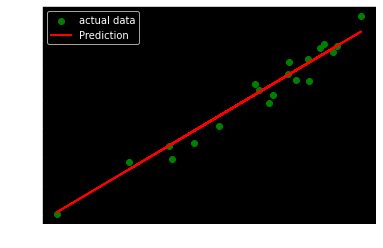

In [27]:
plt.scatter(X_test,y_test,color='green',label='actual data')
plt.plot(X_test,predictions,color='red',linewidth=2,label='Prediction')
plt.legend()
plt.show()